<a href="https://colab.research.google.com/github/AjaybirRandhawa/BrainTumorDetection/blob/main/Brain_Tumor_Detection_with_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Brain Tumor Detection using CNN

Strap in everyone, I'm about to do this all in a 6h semi-concious state with 0 regards to programming guidelines, self care or my mentality. If you find an issue, please, hesitate to fix. Thanks and enjoy o7.

Inspired by: A headache

Coauthors: The voices in my head

In [91]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from sklearn.model_selection import KFold, train_test_split, RandomizedSearchCV
import cv2
import os
from PIL import Image
from keras.preprocessing.image import img_to_array

# Preprocessing
 Before processing the images, lets look at a few random images found in the dataset just to make sure the pathing and uploading of files is correct and functional.

In [92]:
#Inital labeling and division of files
#IMPORTANT: MAKE SURE TO SPELL THEM CORRECTLY
#Total hours wasted without checking: 2
tumor = [('glioma_tumor', 0), ('meningioma_tumor', 1), ('no_tumor', 2), ('pituitary_tumor', 3)]
training_path = '/content/Training/'
testing_path = '/content/Testing/'

In [93]:
#Select random images to check
random_images_path = [
    '/content/Training/glioma_tumor/gg (117).jpg',
    '/content/Training/meningioma_tumor/m (117).jpg',
    '/content/Training/no_tumor/image (10).jpg',
    '/content/Training/pituitary_tumor/p (101).jpg',
    ]
random_images_array = []
for i, image_path in enumerate(random_images_path):
  random_images_array.append(cv2.resize(cv2.imread(image_path, cv2.IMREAD_GRAYSCALE), (200,200)))


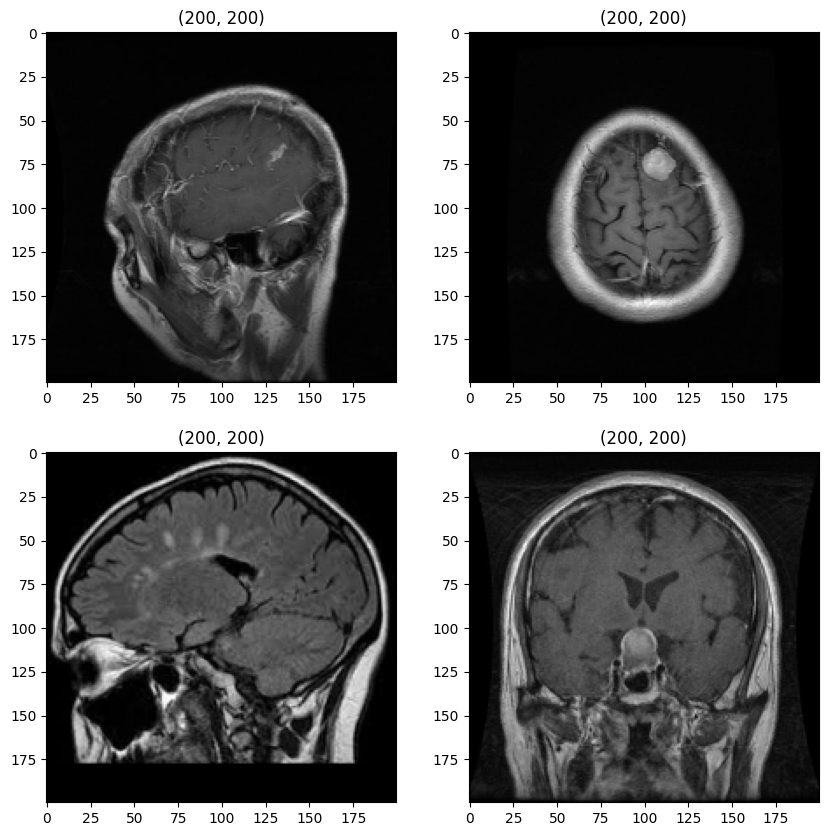

In [94]:
#Display the selected images
plt.figure(figsize  = (10 , 10))
for i, img in enumerate(random_images_array):
  plt.subplot(2, 2, i+1)
  plt.imshow(img,'gray')
  plt.title(img.shape)

plt.show()

# Preprocessing
  Great! Now that the images load and the pathing is correct, lets focus on the core of Machine Learning. The preprocessing.

  To do this, we will simply put what we did above in a function and this time give it the appropriate class labels as well.

In [95]:
#Making a method for getting the array's from both the Training and Testing parts
def get_arrays(path):
  X = []
  y = []
  for cat, value in tumor:
    for img in os.listdir(path+cat):
      img = cv2.resize(cv2.imread(path+cat+'/'+img, cv2.IMREAD_GRAYSCALE), (200,200))
      #Since the files only contain the images, we will use the value we listed in the inital tumor list
      #as the y labels
      y.append(value)
      X.append(img_to_array(Image.fromarray(img)))
  return X,y

In [96]:
X_train, y_train = get_arrays(training_path)
X_test, y_test = get_arrays(testing_path)

In [97]:
#Convert them to numpy array's now and scale from 255 to between 0 and 1
X_train, y_train, X_test, y_test = np.array(X_train), np.array(y_train), np.array(X_test), np.array(y_test)
#Note: Only scale the images so the x values, not the y values as those are already 0,1,2,3
X_train, X_test = X_train/255.0, X_test/255.0
y_train, y_test = np.array(keras.utils.to_categorical(y_train)), np.array(keras.utils.to_categorical(y_test))

In [98]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)

print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)
#Make sure the numbers match up and make sense
#X train has 2870 samples, the images are 200x200, and just 1 layer as its now grayscaled not RGB with 3
#Y train has same number of samples and 4 possible outcomes
#Similar observation for X_test and y_test

X_train shape: (2870, 200, 200, 1)
y_train shape: (2870, 4)
X_test shape: (394, 200, 200, 1)
y_test shape: (394, 4)


In [99]:
#Just putting it in a dictionary format so its easier to convert from y values to their names later on
info = {0 : 'Glioma tumor', 1 : 'Meningioma tumor', 2 : 'No tumor', 3 : 'Pituitary tumor'}

## An important stage
  One of the most important things to do, is check if you have a similar split across all labels. If not, apply some techniques (in this case I will use smote from the imblearn package) to make it so.

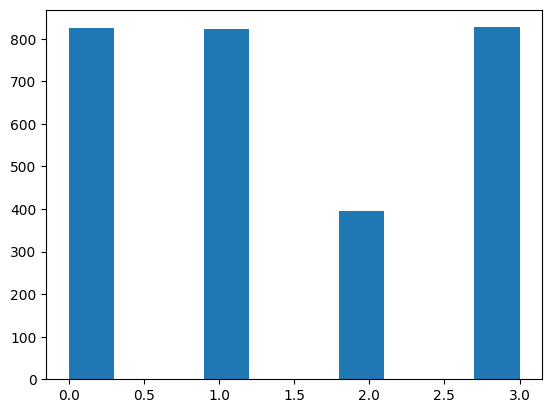

In [100]:
plt.hist(np.argmax(y_train, axis = 1))
plt.show()

As we can see in the Histogram above, 2 (the no tumor category) has a far lower group of samples than the rest of the types. So to prevent any bias for or against it, we will fix this using imblearn.

In [101]:
#To use it, we will reshape X_train first to match y_train (since its the only class that we need to fix the imbalance in)
X_train = np.reshape(X_train, (2870, 200*200*1))
print(X_train.shape)
print(y_train.shape)
from imblearn.over_sampling import SMOTE
#Note: the reason we are passing in y_train as well is so the extra values are also recorded in the y value class
#And so we do not get an imbalance between the two
X_train, y_train = SMOTE(sampling_strategy = 'auto', random_state = 1, k_neighbors = 5).fit_resample(X_train, y_train)
print(X_train.shape)
print(y_train.shape)

(2870, 40000)
(2870, 4)
(3308, 40000)
(3308, 4)


In [102]:
#Reshape back to what X_train was initally now
X_train = np.reshape(X_train, (3308, 200, 200, 1))
print(X_train.shape)
print(y_train.shape)

(3308, 200, 200, 1)
(3308, 4)


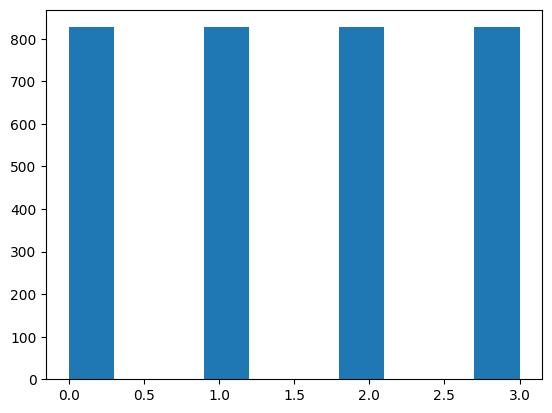

In [103]:
#Check the split now
plt.hist(np.argmax(y_train, axis = 1))
plt.show()

# Building the CNN Model
NOW FOR ACTUAL FUN and the heart of machine learning. If preprocessing is considered the brain, now we're making it think. So lesgoo.

(Unfortunately I do not mean beauty modeling, although for the nerdiest of y'all this will be beautiful).

In [106]:
#Import required layers like input, flatten etc.
from keras.layers import *

In [114]:
#We will write a bunch of sub functions
#that will construct any required layers
def c_layer(filters):

    model = keras.models.Sequential()
    model.add(keras.layers.Conv2D(filters, (3,3), padding = 'same', activation = 'relu'))
    model.add(keras.layers.MaxPooling2D(pool_size = (2,2), padding = 'valid'))
    model.add(keras.layers.BatchNormalization())

    return model
def d_layer(hiddens):

    model = keras.models.Sequential()
    model.add(keras.layers.Dense(hiddens, activation = 'relu', kernel_regularizer = 'l2'))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Dropout(0.2))

    return model

#Now the main function to make the model
def cnn (filter1, filter2, filter3, hidden1, hidden2) :

    model = keras.models.Sequential()

    model.add(keras.layers.Input((200,200,1)))
    model.add(c_layer(filter1))
    model.add(c_layer(filter2))
    model.add(c_layer(filter3))

    model.add(keras.layers.Flatten())
    model.add(d_layer(hidden1))
    model.add(d_layer(hidden2))
    model.add(keras.layers.Dense(4, activation = 'softmax'))
    #I went with an Adam optimizer but you can play around with the learning rate and optimizers if you want to
    model.compile(loss = 'categorical_crossentropy', optimizer = keras.optimizers.Adam(learning_rate = 0.0001), metrics = ['accuracy'])

    return model

In [128]:
from keras.preprocessing.image import ImageDataGenerator
#This is to generate batches of images with real-time data augmentation
generator = ImageDataGenerator(zoom_range = [0.85, 1.0], rotation_range = 3)
generator.fit(X_train)

train_generator = generator.flow(X_train, y_train, batch_size = 32)
train_X, train_y = train_generator.next()


In [129]:
#Now to implement the model
from keras.callbacks import ModelCheckpoint
tracker = ModelCheckpoint('./brain_model.h5', monitor = 'val_accuracy', save_best_only = True, verbose = 1)
model = cnn(128, 64, 32, 128, 64)
print(model.summary())

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_7 (Sequential)   (None, 100, 100, 128)     1792      
                                                                 
 sequential_8 (Sequential)   (None, 50, 50, 64)        74048     
                                                                 
 sequential_9 (Sequential)   (None, 25, 25, 32)        18592     
                                                                 
 flatten_1 (Flatten)         (None, 20000)             0         
                                                                 
 sequential_10 (Sequential)  (None, 128)               2560640   
                                                                 
 sequential_11 (Sequential)  (None, 64)                8512      
                                                                 
 dense_5 (Dense)             (None, 4)                

In [121]:
#Now to fit the model
#NOTE: if you have a potato PC like mine... GL
hist = model.fit(generator.flow(X_train, y_train, batch_size = 32), epochs = 15, validation_data = (X_test,y_test), callbacks = [tracker])

Epoch 1/15
104/104 [==============================] - ETA: 0s - loss: 0.9685 - accuracy: 0.9144
Epoch 1: val_accuracy did not improve from 0.57360
104/104 [==============================] - 820s 8s/step - loss: 0.9685 - accuracy: 0.9144 - val_loss: 2.2940 - val_accuracy: 0.5279
Epoch 2/15
104/104 [==============================] - ETA: 0s - loss: 0.9488 - accuracy: 0.9163
Epoch 2: val_accuracy did not improve from 0.57360
104/104 [==============================] - 797s 8s/step - loss: 0.9488 - accuracy: 0.9163 - val_loss: 3.3354 - val_accuracy: 0.4898
Epoch 3/15
104/104 [==============================] - ETA: 0s - loss: 0.8634 - accuracy: 0.9259
Epoch 3: val_accuracy improved from 0.57360 to 0.59391, saving model to ./brain_model.h5
104/104 [==============================] - 799s 8s/step - loss: 0.8634 - accuracy: 0.9259 - val_loss: 2.6485 - val_accuracy: 0.5939
Epoch 4/15
104/104 [==============================] - ETA: 0s - loss: 0.9117 - accuracy: 0.9151
Epoch 4: val_accuracy did not

Text(0.5, 1.0, 'Loss vs Epochs')

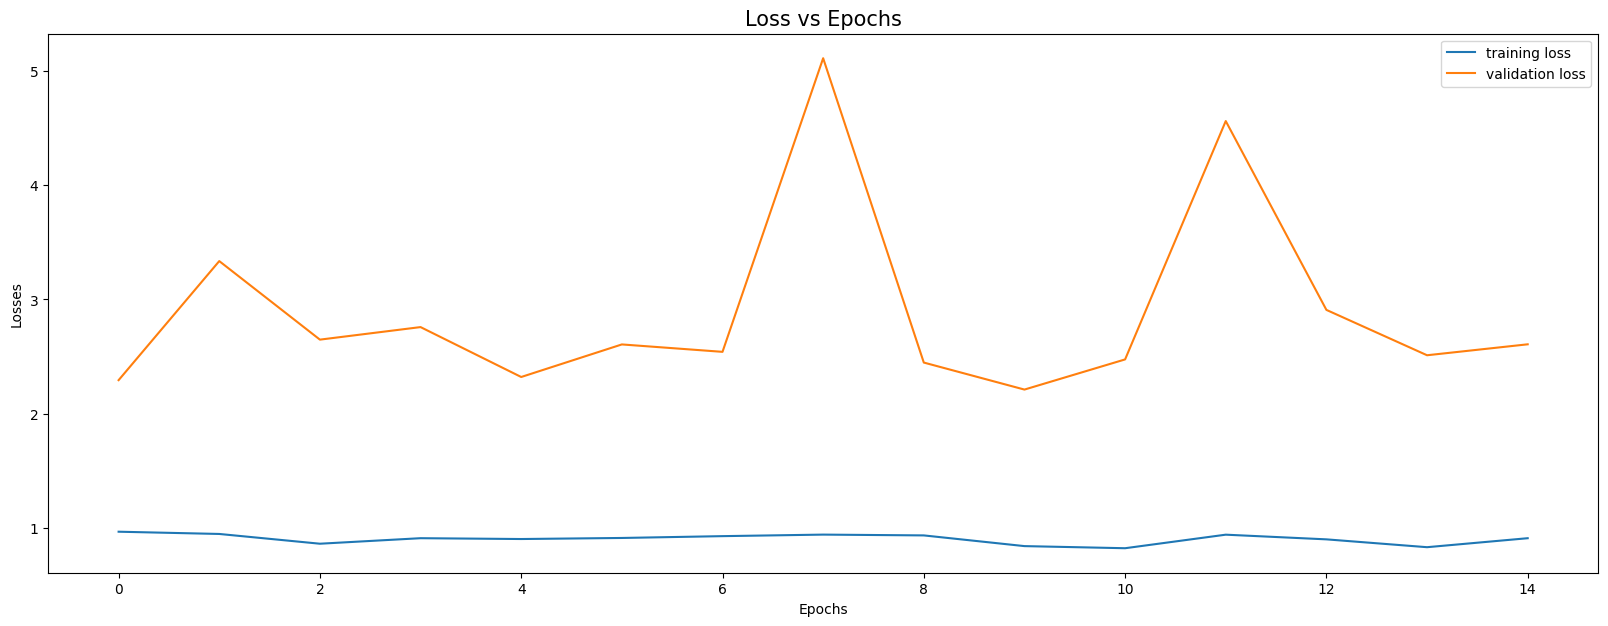

In [123]:
#plotting to see best training epoch numbers vs Loss
plt.figure(figsize = (20,7))
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.legend(['training loss', 'validation loss'])
plt.xlabel('Epochs')
plt.ylabel('Losses')
plt.title('Loss vs Epochs', fontsize = 15)

Text(0.5, 1.0, 'Accuracy vs Epochs')

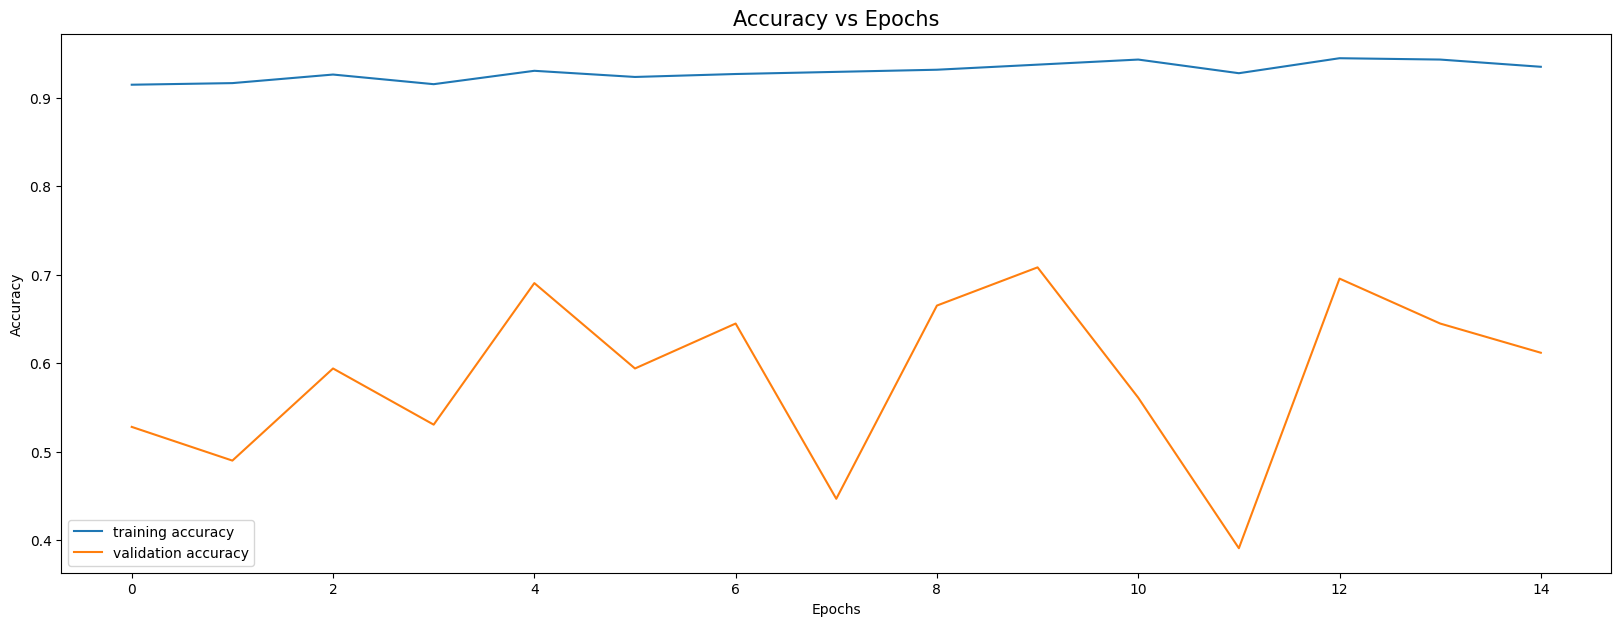

In [124]:
#plotting to see best training epoch numbers vs Accuracy
plt.figure(figsize = (20,7))
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.legend(['training accuracy', 'validation accuracy'])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Epochs', fontsize = 15)

# Prediction

Possibly the most fun you can have in Machine Learning.

In [140]:
from keras.models import load_model
#model = load_model('/content/brain_model.h5')
pred = model.predict(X_test)
print(pred.shape)

13/13 [==============================] - 32s 2s/step
(394, 4)


In [141]:
#Lets print out the predictions and make them readable
val = np.argmax(pred, axis = 1)
pred = np.zeros(pred.shape)
pred[np.arange(pred.shape[0]), val] = 1
#Print out the 1st 5 predictions and their corresponding actual values
print(pred[0:3,:])
print(y_test[0:3,:])

[[0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]]
[[1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]]


In [142]:
#Accuracy score and Classification report
from sklearn.metrics import accuracy_score, classification_report
print('Accuracy : ' + str(accuracy_score(y_test, pred)))
print(classification_report(y_test, pred, target_names = ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']))

Accuracy : 0.19289340101522842
                  precision    recall  f1-score   support

    glioma_tumor       0.22      0.48      0.30       100
meningioma_tumor       0.00      0.00      0.00       115
        no_tumor       0.67      0.02      0.04       105
 pituitary_tumor       0.15      0.35      0.21        74

       micro avg       0.19      0.19      0.19       394
       macro avg       0.26      0.21      0.14       394
    weighted avg       0.26      0.19      0.13       394
     samples avg       0.19      0.19      0.19       394



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
